# CSMODEL S16 MCO1

The dataset used is [Salaries of Different Data Science Fields in the Data Science Domain](https://www.kaggle.com/datasets/arnabchaki/data-science-salaries-2023/data) and obtained from Kaggle that covers data science salaries from 2020 to 2023. It provides data such as work experience, employment type, job titles, and salaries. Our goal is to explore this dataset and gain insights using data modeling techniques.


Collection Process: Data has been sourced from aijobs.net in April 2023 in https://ai-jobs.net/salaries/  Checking the website, it is internally aggregated from the offered salaries in the job listing along with user reported salaries.
The most recent update is within the ai-jobs.net website, that includes 2024.

Possible Implications of Data Collection Method: The dataset focuses primarily on the United States' salaries in the Data Science domain. This is proven given that 86% of the dataset's currency is in USD and 80% of employee_residence is observed to be US.  These factors may lead to inaccurate conclusions as not all countries are distributed properly. The dataset is also heavily skewed towards salaries of full-time workers, with employment_type values of FT taking up 90% of the observations. Additionally, it is unclear whether or not the salaries shown are adjusted for inflation; potentially giving inaccurate salary amounts.

## Imported Libraries

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tabulate import tabulate
from scipy.stats import skew

## Read Dataset

In [29]:
ds_salary_df = pd.read_csv("ds_salaries.csv")
ds_salary_df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


In [30]:
ds_salary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


1. All data types are correct.
2. There are no missing values (null values) present in the dataset.

# Dataset Columns and Descriptions

| Column Name        | Description                                                  |
|--------------------|--------------------------------------------------------------|
| work_year          | The year the salary was paid.                                |
| experience_level   | The experience level in the job during the year with possible values: EN (Entry-level / Junior), MI (Mid-level / Intermediate), SE (Senior-level / Expert), EX (Executive-level / Director). |
| employment_type    | The type of employment for the role with possible values: PT (Part-time), FT (Full-time), CT (Contract), FL (Freelance). |
| job_title          | The role worked in during the year.                          |
| salary             | The total gross salary amount paid. No currency attached.    |
| salary_currency    | The currency of the salary paid as an ISO 4217 currency code.|
| salary_in_usd      | The salary in USD, calculated using statistical data from the BIS and central banks. |
| employee_residence | Employee's primary country of residence during the work year as an ISO 3166 country code. |
| remote_ratio       | The overall amount of work done remotely with possible values: 0 (No remote work), 50 (Partially remote/hybrid), 100 (Fully remote). |
| company_location   | The country of the employer's main office or contracting branch as an ISO 3166 country code. |
| company_size       | The average number of people that worked for the company during the year with possible values: S (less than 50 employees), M (50 to 250 employees), L (more than 250 employees). |


In [31]:
observation_count, variables_count = ds_salary_df.shape

print("Number of observations:", observation_count)
print("Number of variables:", variables_count)

Number of observations: 3755
Number of variables: 11


## Dataset Cleaning

In [32]:
for column in ds_salary_df.columns:
    unique_values = ds_salary_df[column].unique()
    print(f"Unique values in column '{column}': {unique_values}")

Unique values in column 'work_year': [2023 2022 2020 2021]
Unique values in column 'experience_level': ['SE' 'MI' 'EN' 'EX']
Unique values in column 'employment_type': ['FT' 'CT' 'FL' 'PT']
Unique values in column 'job_title': ['Principal Data Scientist' 'ML Engineer' 'Data Scientist'
 'Applied Scientist' 'Data Analyst' 'Data Modeler' 'Research Engineer'
 'Analytics Engineer' 'Business Intelligence Engineer'
 'Machine Learning Engineer' 'Data Strategist' 'Data Engineer'
 'Computer Vision Engineer' 'Data Quality Analyst'
 'Compliance Data Analyst' 'Data Architect'
 'Applied Machine Learning Engineer' 'AI Developer' 'Research Scientist'
 'Data Analytics Manager' 'Business Data Analyst' 'Applied Data Scientist'
 'Staff Data Analyst' 'ETL Engineer' 'Data DevOps Engineer' 'Head of Data'
 'Data Science Manager' 'Data Manager' 'Machine Learning Researcher'
 'Big Data Engineer' 'Data Specialist' 'Lead Data Analyst'
 'BI Data Engineer' 'Director of Data Science'
 'Machine Learning Scientist' 'M

**Observation columns have unique values and are free from typos. But some job titles have inconsistencies, therefore it is subjected for cleaning.**

In [33]:
# Creating new clean dataset
ds_salary_clean = ds_salary_df

### Generalization of Job Titles

To reduce redundancy and standardize job titles, specific ranks such as "Principal" and "Staff" will be generalized. This is done to align with the existing categorization based on experience levels.

1. **Principal Machine Learning Engineer** ➔ Machine Learning Engineer
2. **Staff Data Analyst** ➔ Data Analyst
3. **Staff Data Scientist** ➔ Data Scientist
4. **Principal Data Architect** ➔ Data Architect
5. **Principal Data Engineer** ➔ Data Engineer
6. **Principal Data Analyst** ➔ Data Analyst
7. **Principal Data Scientist** ➔ Data Scientist


In [34]:
ds_salary_clean['job_title'] = ds_salary_df['job_title'].replace({
    'Principal Machine Learning Engineer': 'Machine Learning Engineer',
    'Staff Data Analyst': 'Data Analyst',
    'Staff Data Scientist': 'Data Scientist',
    'Principal Data Architect': 'Data Architect',
    'Principal Data Engineer': 'Data Engineer',
    'Principal Data Analyst': 'Data Analyst',
    'Principal Data Scientist': 'Data Scientist'
})


### Cleaning Duplicated Job Titles

The dataset contains 93 job titles. The dataset's duplicated job listings are cleaned as follows:

1. **ML Engineer** ➔ Machine Learning Engineer (ML is shorthand for Machine Learning)
2. **BI Analyst** ➔  BI Data Analyst (BI = Business Intelligence)
3. **Machine Learning Software Engineer** ➔  Machine Learning Engineer
4. **Lead Data Scientist** ➔ Data Science Lead   

Job titles that appear similar but are not are the following:

1. Data Manager and Data Science Manager
2. BI (Business Intelligence) Data Analyst and Business Data Analyst.

In [35]:
ds_salary_clean['job_title'] = ds_salary_df['job_title'].replace({
    'ML Engineer': 'Machine Learning Engineer',
    'BI Analyst': 'BI Data Analyst',
    'Machine Learning Software Engineer': 'Machine Learning Engineer',
    'Lead Data Scientist': 'Data Science Lead'
})

### Cleaning Administrative Job Titles

For easier viewing, all administrative positions (e.g., manager, lead, consultant, director) are placed at the end of the job title.

1. **Director of Data Science** ➔ Data Science Director
2. **Head of Data** ➔ Data Head
3. **Head of Data Science** ➔ Data Science Head
4. **Head of Machine Learning** ➔ Machine Learning Head
5. **Lead Machine Learning Engineer** ➔ Machine Learning Engineer Lead
6. **Lead Data Analyst** ➔ Data Analyst Lead
7. **Lead Data Engineer** ➔ Data Engineer Lead

In [36]:
ds_salary_clean['job_title'] = ds_salary_df['job_title'].replace({
    'Director of Data Science': 'Data Science Director',
    'Head of Data': 'Data Head',
    'Head of Data Science': 'Data Science Head',
    'Head of Machine Learning': 'Machine Learning Head',
    'Lead Machine Learning Engineer': 'Machine Learning Engineer Lead',
    'Lead Data Analyst': 'Data Analyst Lead',
    'Lead Data Engineer': 'Data Engineer Lead'
})

## Dataset Preprocessing

### Dropping Unnecessary Variables

We have removed variables that are not required for our analysis.
These variables include:

1. **salary**
2. **salary_currency**
3. **employee_residence**

In [37]:
initial_columns = ds_salary_clean.columns.tolist()

# Drop the 'salary', 'salary_currency', and 'employee_residence' columns
ds_salary_clean.drop(columns=['salary', 'salary_currency', 'employee_residence'], inplace=True)

final_columns = ds_salary_clean.columns.tolist()

print("Columns before and after dropping 'salary' and 'salary_currency':")
print(tabulate([["Initial Columns", ", ".join(initial_columns)],
                ["Final Columns", ", ".join(final_columns)]],
               headers=["Stage", "Columns"], tablefmt="grid"))

Columns before and after dropping 'salary' and 'salary_currency':
+-----------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Stage           | Columns                                                                                                                                                           |
+=================+===================================================================================================================================================================+
| Initial Columns | work_year, experience_level, employment_type, job_title, salary, salary_currency, salary_in_usd, employee_residence, remote_ratio, company_location, company_size |
+-----------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Final Column

## Exploratory Data Analysis

### Question 1  - What does the distribution look like?
Since our variable of interest is **'salary_in_usd'** , we will use it as our focus variable.


In [49]:
# Measures of Central Tendency
mean_salary = ds_salary_clean['salary_in_usd'].mean()
median_salary = ds_salary_clean['salary_in_usd'].median()
mode_salary = ds_salary_clean['salary_in_usd'].mode().values[0]  # In case of multiple modes, take the first one

print(f"Mean salary: ${mean_salary:,.2f}")
print(f"Median salary: ${median_salary:,.2f}")
print(f"Mode salary: ${mode_salary:,.2f}")

# Measures of Dispersion
salary_range = ds_salary_clean['salary_in_usd'].max() - ds_salary_clean['salary_in_usd'].min()
salary_variance = ds_salary_clean['salary_in_usd'].var()
salary_std = ds_salary_clean['salary_in_usd'].std()

print(f"Salary range: ${salary_range:,.2f}")
print(f"Salary variance: ${salary_variance:,.2f}")
print(f"Salary standard deviation: ${salary_std:,.2f}")

# Compute correlation matrix for selected numeric columns
numeric_columns = ['salary_in_usd']
numeric_df = ds_salary_clean[numeric_columns]
correlation_matrix = numeric_df.corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)


Mean salary: $137,570.39
Median salary: $135,000.00
Mode salary: $100,000.00
Salary range: $444,868.00
Salary variance: $3,976,011,879.23
Salary standard deviation: $63,055.63

Correlation Matrix:
               salary_in_usd
salary_in_usd            1.0


**Central Tendency:** The mean salary of $137,570.39, median salary of $135,000.00, and mode salary of $100,000.00 indicate that salaries cluster around these values, highlighting typical salary levels in the dataset.

**Dispersion:** A wide salary range of $444,868.00, large variance of $3,976,011,879.23, and standard deviation of $63,055.63 illustrate significant variability in salary levels, reflecting diverse income ranges within the dataset.

**Correlation:** A perfect correlation coefficient of 1.0 between salary_in_usd and itself confirms data consistency but does not reveal relationships with other variables, warranting further exploration.

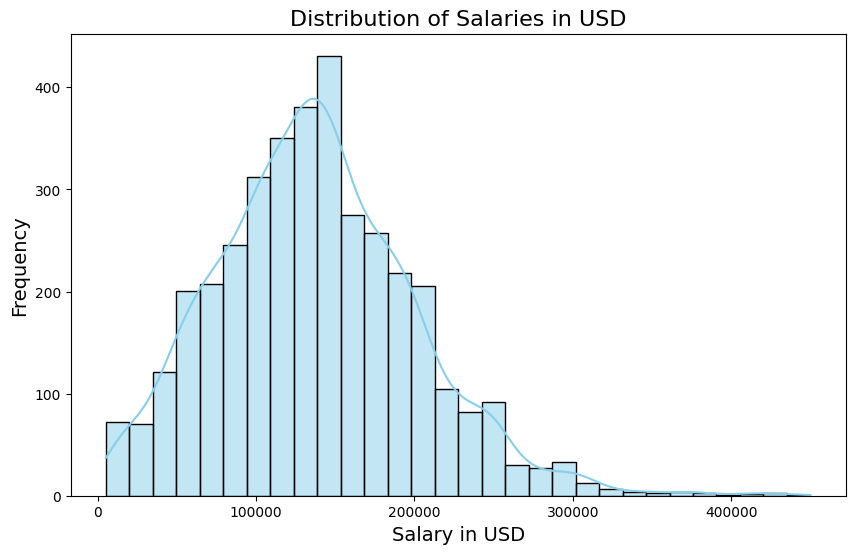

The skewness of the salary distribution is: 0.54


In [39]:
plt.figure(figsize=(10, 6))
sns.histplot(ds_salary_clean['salary_in_usd'], bins=30, kde=True, color='skyblue', edgecolor='black')

plt.title('Distribution of Salaries in USD', fontsize=16)
plt.xlabel('Salary in USD', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.show()

# Skewness of salary_in_usd
salary_data = ds_salary_clean['salary_in_usd']
salary_skewness = skew(salary_data)

print(f"The skewness of the salary distribution is: {salary_skewness:.2f}")


The skewness of the salary distribution is 0.54, indicating a **moderately positively skewed distribution**.  Because of this skewness, some higher salaries have pulled the mean to the right, making the mean salary slightly higher than the median. For most data points, the median provides a better indication of the central tendency than the mode, which is likely lower. This indicates that while there are enough higher wages to produce a moderate positive skew, the majority of pay data points appear to be clustered around a central value.

### Question 2  - What are the most common company locations represented in the dataset?


In [64]:
most_common_location = ds_salary_clean['company_location'].mode()[0]
count_most_common_location = ds_salary_clean['company_location'].value_counts().max()

print("Most common company location:", most_common_location)
print("Count of the most common location:", count_most_common_location)

num_unique_locations = len(ds_salary_clean['company_location'].unique())
print("Number of unique company locations:", num_unique_locations)

company_location_counts = ds_salary_clean['company_location'].value_counts()
company_location_percentages = ds_salary_clean['company_location'].value_counts(normalize=True) * 100

print("\nCompany Location Counts:")
print(company_location_counts)
print("\nCompany Location Percentages:")
print(company_location_percentages)

Most common company location: US
Count of the most common location: 3040
Number of unique company locations: 72

Company Location Counts:
company_location
US    3040
GB     172
CA      87
ES      77
IN      58
      ... 
CN       1
NZ       1
CL       1
MD       1
MT       1
Name: count, Length: 72, dtype: int64

Company Location Percentages:
company_location
US    80.958722
GB     4.580559
CA     2.316911
ES     2.050599
IN     1.544607
        ...    
CN     0.026631
NZ     0.026631
CL     0.026631
MD     0.026631
MT     0.026631
Name: proportion, Length: 72, dtype: float64


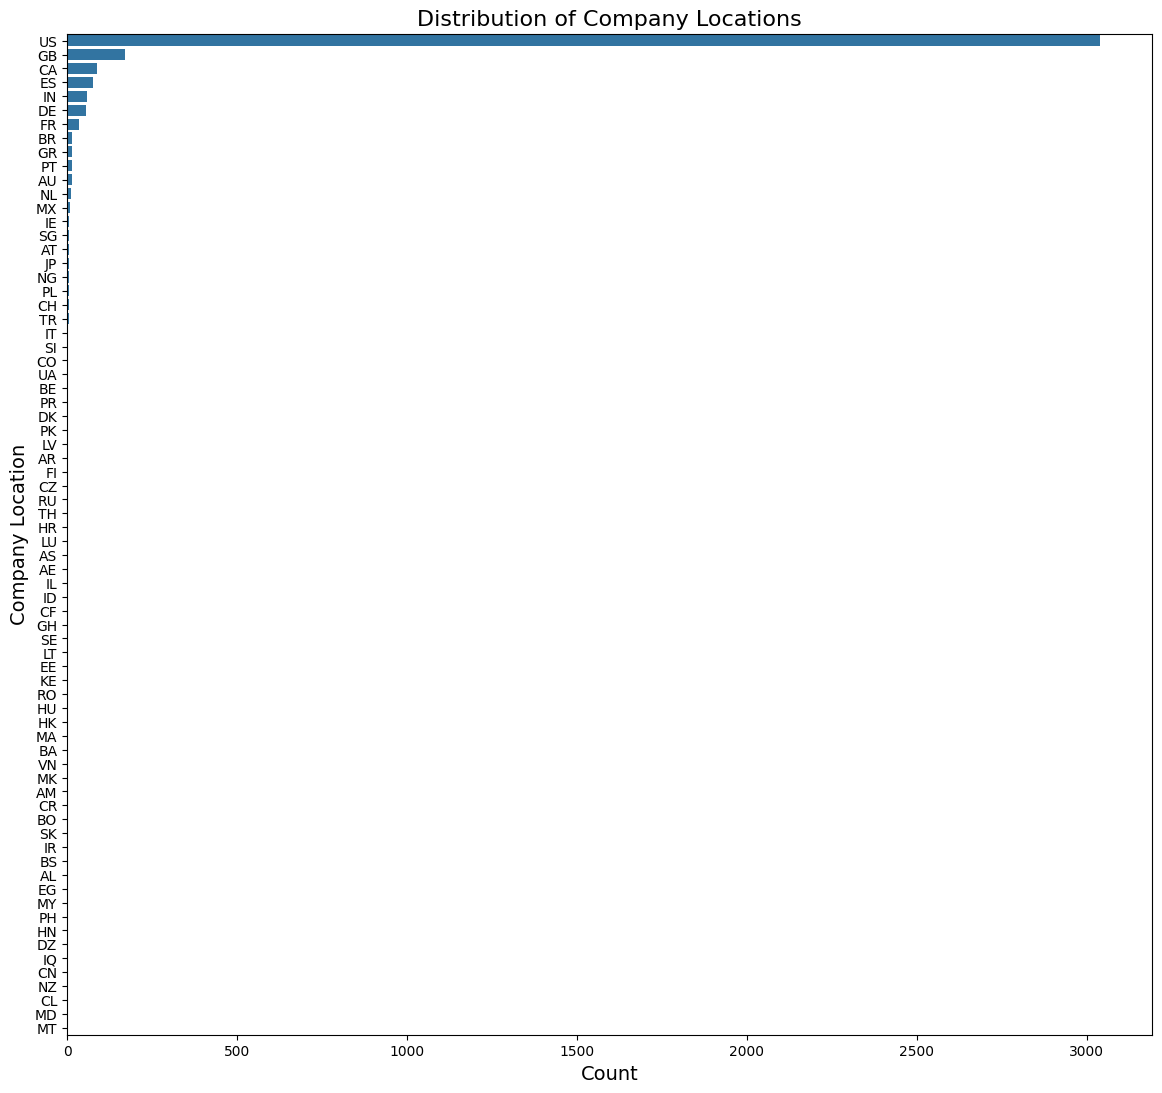

In [65]:
plt.figure(figsize=(14, 13))
sns.countplot(y='company_location', data=ds_salary_clean, order=ds_salary_clean['company_location'].value_counts().index)
plt.title('Distribution of Company Locations', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Company Location', fontsize=14)
plt.show()

The analysis of the **company_location** variable indicates a **convenience bias** towards  the United States market, which hosts the majority of companies in the dataset (3040 out of 3755 observations, or approximately 80.96%). This bias suggests that the dataset may not fully represent global diversity in company locations and could skew insights towards regions with higher data availability or participation. 

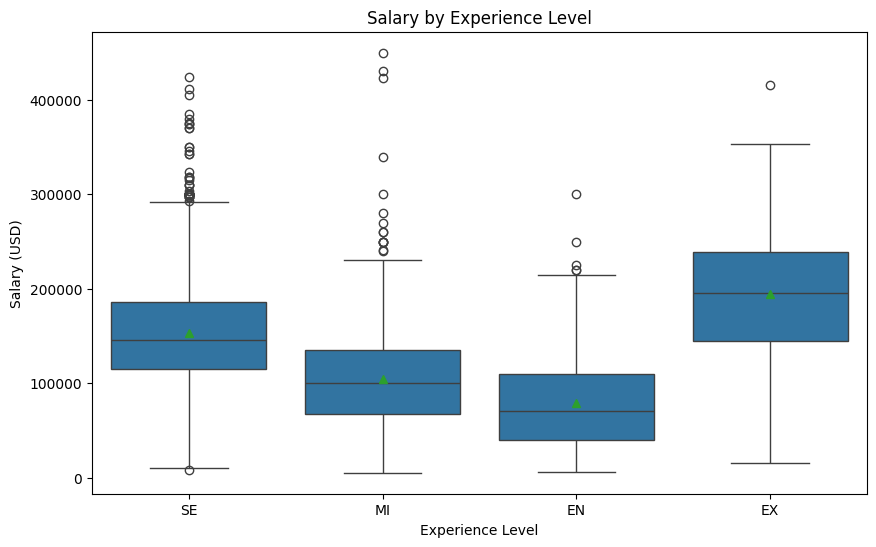

In [ ]:
# Salary vs. Experience Level
plt.figure(figsize=(10,6))
sns.boxplot(
    x = "experience_level",
    y = "salary_in_usd",
    showmeans=True,
    data=ds_salary_clean
)
plt.xlabel('Experience Level')
plt.ylabel('Salary (USD)')
plt.title('Salary by Experience Level')
plt.show()


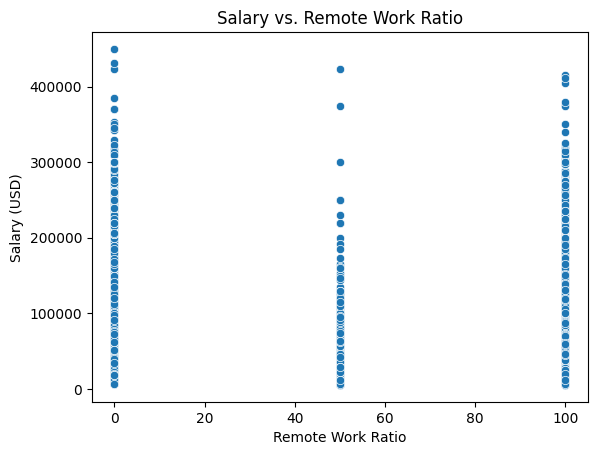

In [ ]:
# Salary and Remote Work
sns.scatterplot(
    x = "remote_ratio",
    y = "salary_in_usd",
    data=ds_salary_clean
)
plt.xlabel('Remote Work Ratio')
plt.ylabel('Salary (USD)')
plt.title('Salary vs. Remote Work Ratio')
plt.show()

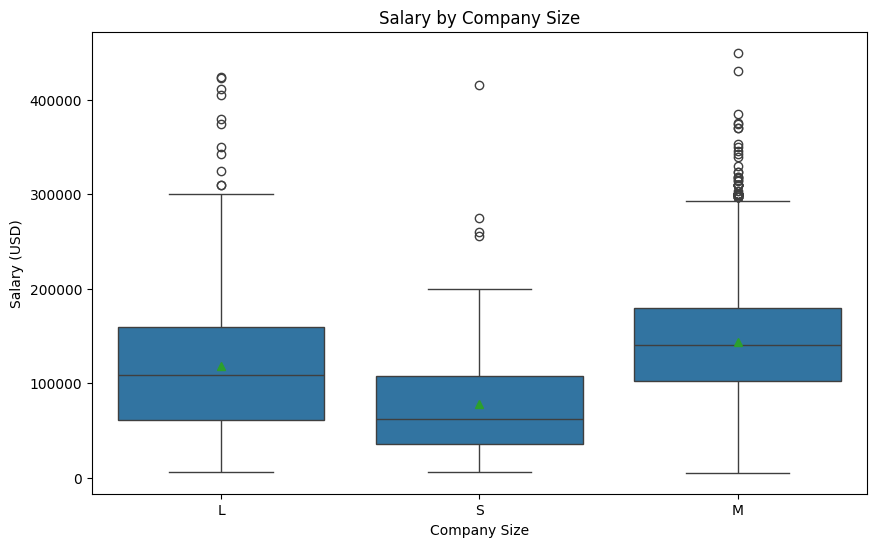

In [ ]:
# Company Analysis - Grouped boxplots
plt.figure(figsize=(10,6))
sns.boxplot(
    x = "company_size",
    y = "salary_in_usd",
    showmeans=True,
    data=ds_salary_clean
)
plt.xlabel('Company Size')
plt.ylabel('Salary (USD)')
plt.title('Salary by Company Size')
plt.show()


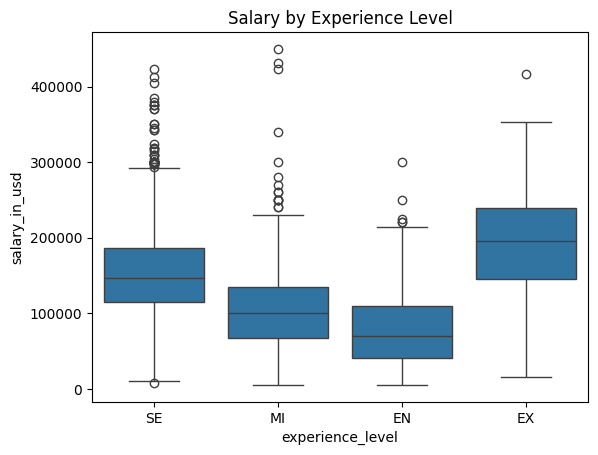

In [ ]:
sns.boxplot(x='experience_level', y='salary_in_usd', data=ds_salary_clean)
plt.title('Salary by Experience Level')
plt.show()

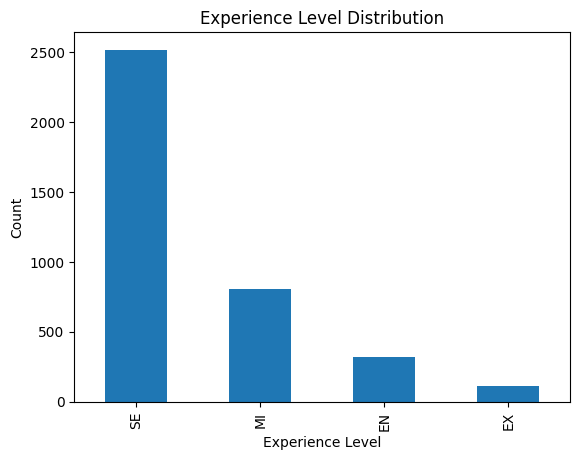

In [ ]:
ds_salary_clean['experience_level'].value_counts().plot(kind='bar')
plt.title('Experience Level Distribution')
plt.xlabel('Experience Level')
plt.ylabel('Count')
plt.show()


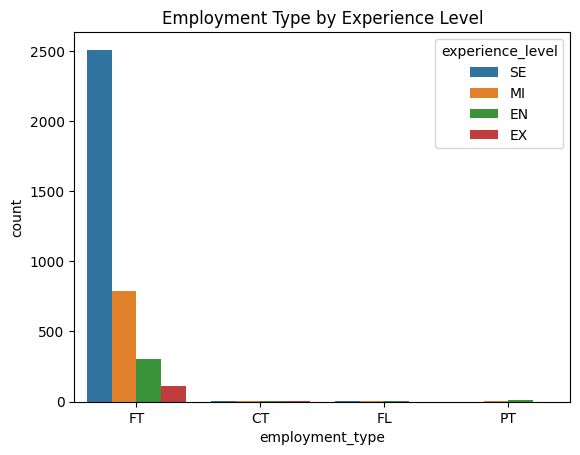

In [ ]:
sns.countplot(x='employment_type', hue='experience_level', data=ds_salary_clean)
plt.title('Employment Type by Experience Level')
plt.show()